In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import cv2, random
import torch
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from diffusers import StableDiffusionControlNetPipeline, \
                      ControlNetModel, \
                      UniPCMultistepScheduler
from diffusers.utils import load_image

def show_img(img, dpi=150, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=dpi)
    ax.set_title( title, fontsize=16, color='black')
    ax.axis('off')
    ax.imshow(img)
    return fig, ax

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

def get_controlNet_pipe(
            controlnet_model_dir, 
            pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1-base"
            ):

    controlnet = ControlNetModel.from_pretrained(str(controlnet_model_dir), torch_dtype=torch.float16)

    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name_or_path, controlnet=controlnet, torch_dtype=torch.float16
    )

    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    pipe.enable_model_cpu_offload()
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

    return pipe

/home/sentan2023/anaconda3/envs/hirahara/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
controlnet_model_dir = Path("thepowefuldeez/sd21-controlnet-canny")
controlnet_pipe = get_controlNet_pipe(controlnet_model_dir)

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 196844.59it/s]


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


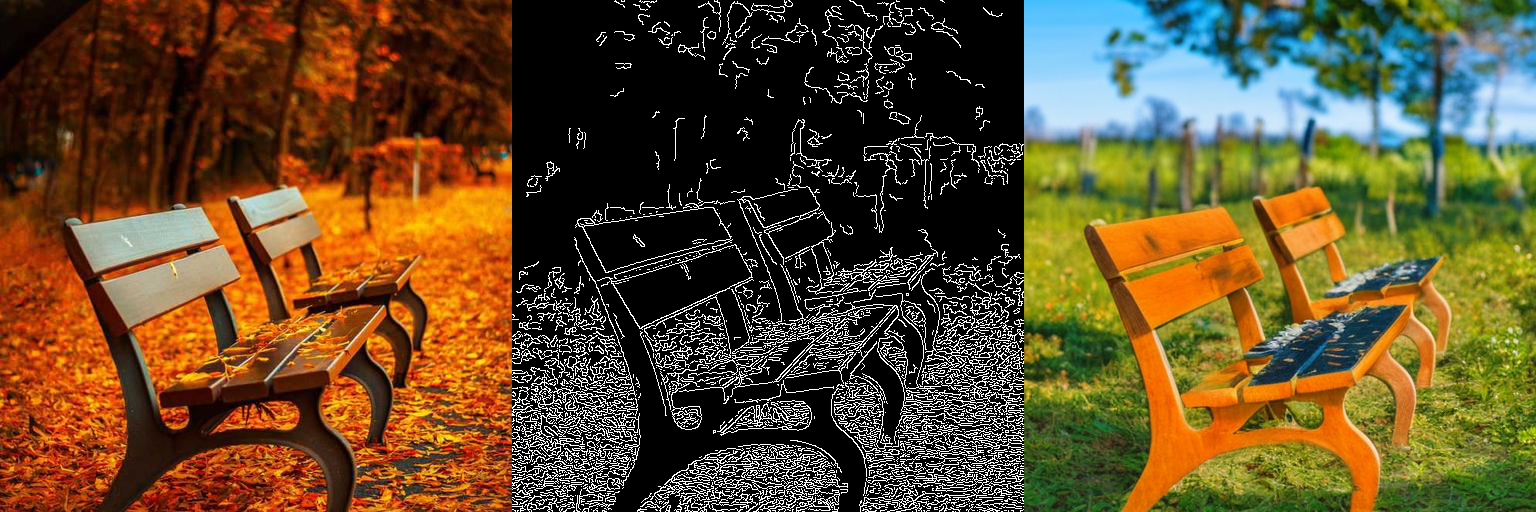

In [10]:
image_url = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
image_url = "https://picsum.photos/512"

target_img = np.array(load_image(image_url))
target_img = cv2.resize(target_img, (512, 512))

source_img = cv2.Canny(target_img, 100, 200)[:, :, None]
source_img = np.concatenate([source_img, source_img, source_img], axis=2)


prompt = "best quality, extremely detailed"
generator = torch.Generator(device="cpu").manual_seed(2)

output = controlnet_pipe(
                prompt,
                Image.fromarray(source_img),
                negative_prompt     = "monochrome, lowres, bad anatomy, worst quality, low quality",
                generator           = generator,
                num_inference_steps = 20,
            )


result_imgs = [Image.fromarray(target_img), Image.fromarray(source_img)] + output.images
image_grid(result_imgs, rows=1, cols=len(result_imgs))
